<img src="https://raw.githubusercontent.com/EO-College/cubes-and-clouds/main/icons/cnc_3icons_process_circle.svg"
     alt="Cubes & Clouds logo"
     style="float: center; margin-right: 10px;" />

# Reduce Operators with Pangeo

## Reduce Operators

When computing statistics over time or indices based on multiple bands, it is possible to use reduce operators.

In Pangeo and `Xarray` we can use the `groupby` method, which applies a reducer to a data cube dimension by collapsing all the values along the specified dimension into an output value computed by the reducer.

Reduce the temporal dimension to a single value, the mean for instance:

In [1]:
# STAC Catalogue Libraries
import pystac_client
import stackstac
import xarray as xr

In [2]:
#                  West,     South,     East,      North
spatial_extent = [11.259613, 46.461019, 11.406212, 46.522237]
temporal_extent = ["2021-05-28T00:00:00Z","2021-06-30T00:00:00Z"]

In [3]:
URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)
s2_items = catalog.search(
    bbox=spatial_extent,
    datetime=temporal_extent,
    collections=["sentinel-2-l2a"]
).item_collection()

s2_cube = stackstac.stack(s2_items,
                     bounds_latlon=spatial_extent,
                     assets=["red","nir"]
)
s2_cube

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-b671372a6175b16d2e4eaf48f5606039' (time: 26,
                                                                band: 2,
                                                                y: 714, x: 1146)>
dask.array<fetch_raster_window, shape=(26, 2, 714, 1146), dtype=float64, chunksize=(1, 1, 714, 1024), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2021-05-28...
    id                                       (time) <U24 'S2B_32TPS_20210528_...
  * band                                     (band) <U3 'red' 'nir'
  * x                                        (x) float64 6.733e+05 ... 6.848e+05
  * y                                        (y) float64 5.155e+06 ... 5.148e+06
    s2:unclassified_percentage               (time) float64 0.2507 ... 2.393
    ...                                       ...
    proj:transform                           object {0, 600000, 10, 5200020, ...
    title                                    (band) <U20 'Red (band 4) - 10m'...
    common_name                              (band) <U3 'red' 'nir'
    center_wavelength                        (band) float64 0.665 0.842
    full_width_half_max                      (band) float64 0.038 0.145
    epsg                                     int64 32632
Attributes:
    spec:        RasterSpec(epsg=32632, bounds=(673310.0, 5147750.0, 684770.0...
    crs:         epsg:32632
    transform:   | 10.00, 0.00, 673310.00|\n| 0.00,-10.00, 5154890.00|\n| 0.0...
    resolution:  10.0

### Get rid of possible negative values

In [4]:
s2_cube = xr.where(s2_cube>=0, s2_cube, 0)

Reduce the `time` dimension by averaging along the `time` dimension. Check what happens to the datacube inspecting the resulting xArray object:

In [5]:
datacube_mean_time = s2_cube.mean("time")
datacube_mean_time

<xarray.DataArray 'stackstac-b671372a6175b16d2e4eaf48f5606039' (band: 2,
                                                                y: 714, x: 1146)>
dask.array<mean_agg-aggregate, shape=(2, 714, 1146), dtype=float64, chunksize=(1, 714, 1024), chunktype=numpy.ndarray>
Coordinates: (12/21)
  * band                                     (band) <U3 'red' 'nir'
  * x                                        (x) float64 6.733e+05 ... 6.848e+05
  * y                                        (y) float64 5.155e+06 ... 5.148e+06
    s2:product_type                          <U7 'S2MSI2A'
    s2:datatake_type                         <U8 'INS-NOBS'
    proj:epsg                                int64 32632
    ...                                       ...
    proj:transform                           object {0, 600000, 10, 5200020, ...
    title                                    (band) <U20 'Red (band 4) - 10m'...
    common_name                              (band) <U3 'red' 'nir'
    center_wavelength                        (band) float64 0.665 0.842
    full_width_half_max                      (band) float64 0.038 0.145
    epsg                                     int64 32632

It is possible to reduce in the same way all the available dimensions of the datacube.

We can, for instance, reduce the band dimension similarly as we did for the temporal dimension:

The result will now contain values resulting from the average of the bands:

In [6]:
datacube_mean_band = s2_cube.mean("band")
datacube_mean_band

<xarray.DataArray 'stackstac-b671372a6175b16d2e4eaf48f5606039' (time: 26,
                                                                y: 714, x: 1146)>
dask.array<mean_agg-aggregate, shape=(26, 714, 1146), dtype=float64, chunksize=(1, 714, 1024), chunktype=numpy.ndarray>
Coordinates: (12/48)
  * time                                     (time) datetime64[ns] 2021-05-28...
    id                                       (time) <U24 'S2B_32TPS_20210528_...
  * x                                        (x) float64 6.733e+05 ... 6.848e+05
  * y                                        (y) float64 5.155e+06 ... 5.148e+06
    s2:unclassified_percentage               (time) float64 0.2507 ... 2.393
    s2:product_type                          <U7 'S2MSI2A'
    ...                                       ...
    s2:degraded_msi_data_percentage          (time) object 0.0112 0 ... 0.0127 0
    earthsearch:payload_id                   (time) <U74 'roda-sentinel2/work...
    gsd                                      int64 10
    proj:shape                               object {10980}
    proj:transform                           object {0, 600000, 10, 5200020, ...
    epsg                                     int64 32632

**Quiz hint: look carefully at number of pixels of the loaded datacube!**

The reducer could be again a single process, but when computing spectral indices like NDVI, NDSI etc. an arithmentical formula is used instead.

For instance, the [NDVI](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) formula can be expressed using a `reduce_dimension` process over the `bands` dimension:

$$ NDVI = {{NIR - RED} \over {NIR + RED}} $$

In [7]:
def NDVI(data):
    red = data.sel(band="red")
    nir = data.sel(band="nir")
    ndvi = (nir - red)/(nir + red)
    return ndvi

ndvi_xr = NDVI(s2_cube)
ndvi_xr

<xarray.DataArray 'stackstac-b671372a6175b16d2e4eaf48f5606039' (time: 26,
                                                                y: 714, x: 1146)>
dask.array<truediv, shape=(26, 714, 1146), dtype=float64, chunksize=(1, 714, 1024), chunktype=numpy.ndarray>
Coordinates: (12/48)
  * time                                     (time) datetime64[ns] 2021-05-28...
    id                                       (time) <U24 'S2B_32TPS_20210528_...
  * x                                        (x) float64 6.733e+05 ... 6.848e+05
  * y                                        (y) float64 5.155e+06 ... 5.148e+06
    s2:unclassified_percentage               (time) float64 0.2507 ... 2.393
    s2:product_type                          <U7 'S2MSI2A'
    ...                                       ...
    s2:degraded_msi_data_percentage          (time) object 0.0112 0 ... 0.0127 0
    earthsearch:payload_id                   (time) <U74 'roda-sentinel2/work...
    gsd                                      int64 10
    proj:shape                               object {10980}
    proj:transform                           object {0, 600000, 10, 5200020, ...
    epsg                                     int64 32632

Visualize a sample NDVI result:

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 650 ms, sys: 129 ms, total: 779 ms
Wall time: 4.33 s


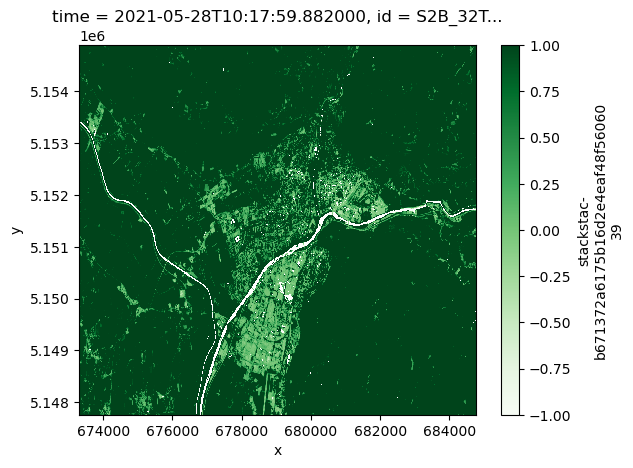

In [8]:
%%time
ndvi_xr.isel(time=0).plot.imshow(vmin=-1,vmax=1,cmap="Greens")

Additionally, it is possible to reduce both spatial dimensions of the datacube at the same time.

To do this, we need the `reduce_spatial` process.

This time we select a smaller area of interest, to reduce the amount of downloaded data:

In [9]:
#                  West,     South,     East,      North
spatial_extent = [11.31369, 46.52167, 11.31906, 46.52425]
temporal_extent = ["2021-01-01T00:00:00Z","2021-12-30T00:00:00Z"]
bands = ["red","nir"]

In [10]:
URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)
s2_items = catalog.search(
    bbox=spatial_extent,
    datetime=temporal_extent,
    collections=["sentinel-2-l2a"]
).item_collection()

s2_cube = stackstac.stack(s2_items,
                     bounds_latlon=spatial_extent,
                     assets=bands
)
s2_cube = s2_cube[s2_cube["eo:cloud_cover"] < 15]

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


### Get rid of possible negative values

In [11]:
s2_cube = xr.where(s2_cube>=0, s2_cube, 0)

### Reduce dimension x and y with median values

In [12]:
datacube_spatial_median = s2_cube.median(dim=["x", "y"])

Verify that the spatial dimensions were collapsed:

In [13]:
datacube_spatial_median

<xarray.DataArray 'stackstac-7710f08aba1196bc4f45cd73b40041b2' (time: 65,
                                                                band: 2)>
dask.array<nanmedian, shape=(65, 2), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates: (12/51)
  * time                                     (time) datetime64[ns] 2021-01-11...
    id                                       (time) <U24 'S2B_32TPS_20210111_...
  * band                                     (band) <U3 'red' 'nir'
    s2:unclassified_percentage               (time) object 0.001827 ... 5.000642
    s2:product_type                          <U7 'S2MSI2A'
    s2:sequence                              (time) <U1 '1' '3' '0' ... '0' '0'
    ...                                       ...
    proj:transform                           object {0, 600000, 10, 5200020, ...
    title                                    (band) <U20 'Red (band 4) - 10m'...
    common_name                              (band) <U3 'red' 'nir'
    center_wavelength                        (band) float64 0.665 0.842
    full_width_half_max                      (band) float64 0.038 0.145
    epsg                                     int64 32632

We can combine this spatial reducer with the previous over bands to compute a time series of NDVI values:

In [14]:
ndvi_spatial_xr = NDVI(datacube_spatial_median)
ndvi_spatial_xr

<xarray.DataArray 'stackstac-7710f08aba1196bc4f45cd73b40041b2' (time: 65)>
dask.array<truediv, shape=(65,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2021-01-11...
    id                                       (time) <U24 'S2B_32TPS_20210111_...
    s2:unclassified_percentage               (time) object 0.001827 ... 5.000642
    s2:product_type                          <U7 'S2MSI2A'
    s2:sequence                              (time) <U1 '1' '3' '0' ... '0' '0'
    s2:generation_time                       (time) <U27 '2023-05-31T05:43:03...
    ...                                       ...
    s2:degraded_msi_data_percentage          (time) object 0.0223 0.025 ... 0 0
    earthsearch:payload_id                   (time) <U74 'roda-sentinel2/work...
    gsd                                      int64 10
    proj:shape                               object {10980}
    proj:transform                           object {0, 600000, 10, 5200020, ...
    epsg                                     int64 32632

In [15]:
ndvi_spatial_xr.load()

<xarray.DataArray 'stackstac-7710f08aba1196bc4f45cd73b40041b2' (time: 65)>
array([1.        , 1.        , 0.72450176, 1.        , 0.69950249,
       1.        , 0.55233069, 1.        , 0.6202058 , 0.63488844,
       1.        , 0.69789227, 1.        , 0.69595376, 1.        ,
       0.70536829, 1.        , 0.71320346, 0.63970998, 1.        ,
       0.6643002 , 1.        , 0.66222645, 0.77107365, 1.        ,
       0.70346552, 0.81553398, 1.        , 0.80752841, 0.83191411,
       0.81575657, 0.82283105, 0.84372402, 1.        , 0.83625219,
       0.81262327, 1.        , 0.8295082 , 1.        , 0.84407484,
       1.        , 0.8255814 , 1.        , 0.84149419, 1.        ,
       0.82274742, 1.        , 0.70364437, 1.        , 0.82560706,
       0.77223851, 0.80659341, 1.        , 0.80912863, 0.76804734,
       0.7275    , 0.77817963, 1.        , 0.99874135, 0.86932447,
       0.82356729, 1.        , 1.        , 0.79028436, 0.78220286])
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2021-01-11...
    id                                       (time) <U24 'S2B_32TPS_20210111_...
    s2:unclassified_percentage               (time) object 0.001827 ... 5.000642
    s2:product_type                          <U7 'S2MSI2A'
    s2:sequence                              (time) <U1 '1' '3' '0' ... '0' '0'
    s2:generation_time                       (time) <U27 '2023-05-31T05:43:03...
    ...                                       ...
    s2:degraded_msi_data_percentage          (time) object 0.0223 0.025 ... 0 0
    earthsearch:payload_id                   (time) <U74 'roda-sentinel2/work...
    gsd                                      int64 10
    proj:shape                               object {10980}
    proj:transform                           object {0, 600000, 10, 5200020, ...
    epsg                                     int64 32632

Remember that calling `.load()` on an xarray + dask based object will load into memory the data.
In this case it will trigger the download of the data from the STAC Catalog and the processing defined as openEO process graph, computing the NDVI time series.

Visualize the NDVI time series:

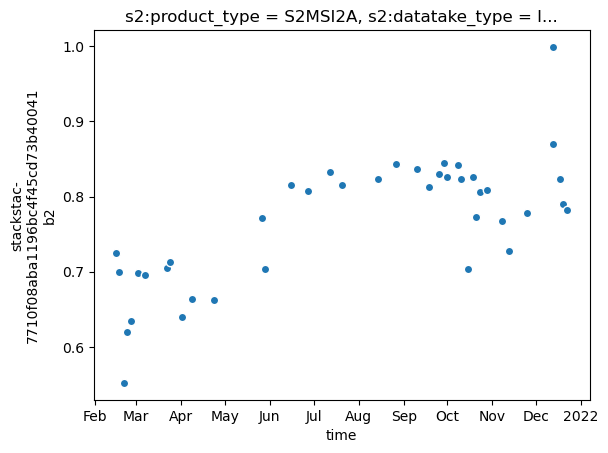

In [16]:
ndvi_spatial_xr.where(ndvi_spatial_xr<1).plot.scatter()